In [ ]:
! pip install openpyxl
! pip install nltk

import nltk
import pandas as pd
from datetime import datetime
from datetime import timedelta
import re
import nltk

nltk.download('punkt')
nltk.download('wordnet')
nltk.download("stopwords")

from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

! pip install gensim

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# ! pip install spacy==3.0
# import spacy

import matplotlib.pyplot as plt


!pip install burst_detection

import burst_detection as bd
import numpy as np

In [ ]:
! pip install -U spacy
! python -m spacy download en_core_web_sm
import spacy
nlp = spacy.load("en_core_web_sm", exclude=['parser', 'ner'])

# nlp.disable_pipes('ner', 'parser')

# nlp.add_pipe("lemmatizer", config={"mode": "lookup"}).initialize()
! spacy validate
print(nlp.pipe_names)

In [ ]:
#dataSet
dataSet = pd.read_csv("matchDataSetTemp.csv", error_bad_lines=False,encoding='latin1',engine="python")

#stopWords
stop_words = stopwords.words("english")

#cleaning the dataset using re
data = dataSet.Tweet.values.tolist()
data = [re.sub(r"http\S+", "", str(t)) for t in data]
dataForPhrases = [re.sub("@[A-Za-z0-9]+","", str(t)) for t in data]
data = [re.sub(r'[^\w\s]','',str(t)) for t in dataForPhrases]    
data = [re.sub(r'\n', '', str(t)) for t in data]
data = [re.sub(r'\r', '', str(t)) for t in data]
# data = [re.sub('\s+',' ',str(t)) for t in data]

#tokenization process
def sentToWords(tweets):
    for tweet in tweets:
        yield(gensim.utils.simple_preprocess(str(tweet), deacc=True, max_len=15))

#tokenized data
dataWords = list(sentToWords(data))

#Build the bigram and trigram models
bigram = gensim.models.Phrases(dataWords, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[dataWords], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# def lemmatization(texts):
#     porter = PorterStemmer()
#     texts_out = []
#     for sent in texts:
#         texts_out.append([porter.stem(token) for token in sent])
#     return texts_out

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    nouns = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        for token in doc:
           if(token.pos_ == 'NOUN' and token.lemma_ not in nouns):
             nouns.append(token.lemma_)

        # nouns.append(token.text for token in doc if token.tag_ in ['NN', 'NNS', 'NNP', 'NNPS'] and token.text not in nouns  )
    return texts_out,nouns


In [ ]:
# Do lemmatization
#run nlp disable pipes before
#data_lemmatized = lemmatization(data_words_bigrams)
data_lemmatized, nouns = lemmatization(dataWords)

# Remove Stop Words
data_words_nostops = remove_stopwords(data_lemmatized)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [ ]:
List_flat = []

for i in range(len(data_words_bigrams)): #Traversing through the main list
  for j in range (len(data_words_bigrams[i])): #Traversing through each sublist
    List_flat.append(data_words_bigrams[i][j]) #Appending elements into our flat_list

In [ ]:
from collections import Counter

Counter = Counter(List_flat)
most_occur = Counter.most_common(100)
topNouns = []

for word,num in most_occur:
  for noun in nouns:
    if(word.find(noun) > 0):
      topNouns.append(word)
      break
  

print(topNouns)
print(len(topNouns))



['final', 'match', 'win', 'euro', 'get', 'player', 'good', 'team', 'time', 'watch', 'play', 'day', 'celebrate', 'today', 'tonight', 'tomorrow', 'make', 'live', 'year', 'position', 'give', 'first', 'copa', 'fan', 'dance', 'recently', 'singing', 'englandas', 'tournament', 'see', 'take', 'game', 'ita', 'score', 'football', 'last', 'say', 'amp', 'come', 'ahead', 'think', 'want', 'ticket', 'look', 'follow', 'big', 'know', 'show', 'name', 'goal', 'start', 'still', 'hope', 'top', 'night', 'scene', 'great', 'need', 'people', 'stream', 'friend', 'even', 'trophy', 'single', 'support', 'reach', 'champion', 'well', 'beat', 'home', 'wish', 'man', 'international', 'end', 'retweet', 'send', 'history', 'link', 'country', 'chance', 'mean', 'put', 'season', 'record', 'never', 'way', 'next', 'back', 'hour', 'threelion', 'title', 'ððððð³ð']
92


In [ ]:
onlyNouns = []
for nn in topNouns:
  dddd= nlp(nn)
  for idx,token in enumerate(dddd):
    if(token.pos_ != "VERB"):
      onlyNouns.append(nn)
len(onlyNouns)

57

In [ ]:
dataSet=dataSet.rename(columns = {'ï»¿Time': 'Time'}, inplace = False)
searchData=([(" ".join(sent)) for sent in data_words_bigrams ])
contents = pd.Series(searchData)
# timeStamp = pd.Series(list(dataSet.Time))
timeStamp = pd.Series(list(dataSet.Date))

cleanContent = pd.concat([contents, timeStamp], axis=1)
cleanContent.columns=["Tweet","Date"]

cleanContent

,Tweet,Date
0,top club plan breakaway league,7/9/2021 19:46
1,wwe money bank full match,7/9/2021 19:46
2,distract make final phe release report show de...,7/9/2021 19:46
3,time kindly albany gruff throw together matchm...,7/9/2021 19:46
4,ðo raheem_sterling lead way successful_dribble...,7/9/2021 19:46
...,...,...
286317,semifinal win fan tell feel aevery black minor...,7/12/2021 18:01
286318,maaam doesnat match youare energy iad hit asso...,7/12/2021 18:01
286319,know count nineniner final season brooklyn arr...,7/12/2021 18:01
286320,final act complete lineup new showcase amazing,7/12/2021 18:01


In [ ]:
targetTweetFreq=[]

for i in onlyNouns:
  targetTweetFreq.append([])

In [ ]:
def findWord(text):
  foundIn = [0]*len(onlyNouns)
  for idx, noun in enumerate(onlyNouns):
    if(text.find(noun) > 0):
      foundIn[idx]=1
  return foundIn

def putInMain(a):
  for idx, num in enumerate(a):
    targetTweetFreq[idx].append(num)

In [ ]:
# date_time_str = '8/25/2017 14:44'
date_time_str = '7/9/2021 19:46'
dateTimeStart = datetime.strptime(date_time_str, '%m/%d/%Y  %H:%M')
margin_date_and_time = dateTimeStart + timedelta(hours=2)

nounsfreq = [0]*len(onlyNouns)

for index, row in cleanContent.iterrows():
  if(datetime.strptime(row.Date, '%m/%d/%Y  %H:%M') < pd.to_datetime(margin_date_and_time)):
    foundIn = findWord(row.Tweet)
    for idx,fi in enumerate(foundIn):
      if(fi == 1):
        nounsfreq[idx]+=1
  else:
    margin_date_and_time = datetime.strptime(((cleanContent.iloc[[index+1]]).Date).item(), '%m/%d/%Y  %H:%M') + timedelta(hours=2)
    putInMain(nounsfreq)
    nounsfreq = [0]*len(onlyNouns)

putInMain(nounsfreq)

In [ ]:
len(targetTweetFreq[50])

8

In [ ]:
date_time_str = '7/9/2021 19:46'
dateTimeStart = datetime.strptime(date_time_str, '%m/%d/%Y  %H:%M')
margin_date_and_time = dateTimeStart + timedelta(hours=2)

time_slice = []
windows_dates = []

i = 0
for index, row in cleanContent.iterrows():
  if(datetime.strptime(row.Date, '%m/%d/%Y  %H:%M') < pd.to_datetime(margin_date_and_time)):
    i+=1

  else:
    windows_dates.append(margin_date_and_time)
    margin_date_and_time = datetime.strptime(((cleanContent.iloc[[index+1]]).Date).item(), '%m/%d/%Y  %H:%M') + timedelta(hours=2)
    time_slice.append(i)
    i = 0

time_slice.append(i)
windows_dates.append(margin_date_and_time)

In [ ]:
len(time_slice)

8

In [ ]:
len(windows_dates)

8

In [ ]:
time_slice = [15993, 9007, 23194, 28995, 23931, 22263, 12233, 6463, 4842, 7321, 10934]

In [ ]:
candidates = []
windows = []
for idx, arr in enumerate(targetTweetFreq):
  #number of target events at each time point
  r = np.array(arr, dtype=float)
  #total number of events at each time point
  d = np.array(time_slice, dtype=float)
  #number of time points
  n = len(r)

  #find the optimal state sequence (q)
  q, d, r, p = bd.burst_detection(r,d,n,s=2,gamma=1,smooth_win=1)

  #enumerate bursts based on the optimal state sequence
  bursts = bd.enumerate_bursts(q, 'burstLabel')

  #find weight of bursts
  weighted_bursts = bd.burst_weights(bursts,r,d,p)
  if(len(weighted_bursts) > 0):
    heavyBurst = False
    for index, row in weighted_bursts.iterrows():
      if(row['weight'] > 100):
        heavyBurst = True

    #visualization for bursts
    if(heavyBurst):
      #visualization for bursts
      candidates.append(onlyNouns[idx])
      windows.append((q.T))
      print(onlyNouns[idx] + " is bursty")
      print ('observed probabilities: ')
      print (str(r/d))

      print ('optimal state sequence: ')
      print (str(q.T))

      print ('baseline probability: ' + str(p[0]))

      print ('bursty probability: ' + str(p[1]))

      print ('weighted bursts:')
      print (weighted_bursts)
      print("")

euro is bursty
observed probabilities: 
[0.10299942 0.100536   0.11092439 0.09529964 0.05130665 0.05255848
 0.16304277 0.15195289]
optimal state sequence: 
[[0. 0. 0. 0. 0. 0. 1. 0.]]
baseline probability: 0.10952272846340569
bursty probability: 0.21904545692681138
weighted bursts:
        label  begin  end  weight
0  burstLabel      6    6  145.93

player is bursty
observed probabilities: 
[0.02372134 0.02129509 0.03337101 0.05098293 0.03234182 0.17012056
 0.04168386 0.05361409]
optimal state sequence: 
[[0. 0. 0. 0. 0. 1. 0. 0.]]
baseline probability: 0.045973840001397065
bursty probability: 0.09194768000279413
weighted bursts:
        label  begin  end   weight
0  burstLabel      5    5  1384.69

today is bursty
observed probabilities: 
[0.02173029 0.0181805  0.02438879 0.02406299 0.02331094 0.00877827
 0.04051089 0.01111173]
optimal state sequence: 
[[0. 0. 0. 0. 0. 0. 1. 0.]]
baseline probability: 0.024298412587534707
bursty probability: 0.048596825175069414
weighted bursts:
     

In [ ]:
event_plots[0]

array([13367,  3905, 22918, 18441,  3492,  2643, 20934,  6459])

In [ ]:
windows_dates = ['8/25/2017 14:44',
 '8/25/2017 16:44',
 '8/25/2017 20:05',
 '8/25/2017 22:05',
 '8/26/2017 0:05',
 '8/26/2017 2:05',
 '8/26/2017 4:05',
 '8/26/2017 6:05',
 '8/26/2017 8:05',
 '8/26/2017 10:05',
 '8/26/2017 12:05']

In [ ]:
windows

[array([[0., 0., 0., 0., 0., 0., 1., 0.]]),
 array([[0., 0., 0., 0., 0., 1., 0., 0.]]),
 array([[0., 0., 0., 0., 0., 0., 1., 0.]]),
 array([[0., 0., 0., 0., 0., 0., 1., 0.]]),
 array([[0., 0., 1., 1., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 0., 0., 0., 1., 0.]]),
 array([[0., 0., 1., 0., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 0., 1., 1., 0., 0.]]),
 array([[0., 0., 1., 0., 0., 0., 0., 0.]]),
 array([[0., 0., 1., 0., 0., 0., 0., 0.]]),
 array([[0., 0., 1., 0., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 0., 0., 1., 0., 0.]]),
 array([[0., 0., 0., 0., 0., 0., 1., 0.]]),
 array([[0., 0., 0., 1., 0., 0., 0., 1.]]),
 array([[1., 1., 0., 0., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 0., 0., 1., 1., 0.]]),
 array([[0., 0., 0., 0., 1., 1., 0., 0.]]),
 array([[0., 0., 0., 0., 0., 0., 0., 1.]]),
 array([[0., 0., 0., 0., 0., 1., 0., 0.]]),
 array([[0., 0., 0., 0., 0., 0., 1., 0.]]),
 array([[0., 0., 1., 0., 0., 0., 0., 0.]]),
 array([[1., 1., 0., 0., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 0., 0., 1.,

In [ ]:
len(candidates)

33

In [ ]:
!pip install distance
import numpy as np
from sklearn.cluster import AffinityPropagation
import distance
    
words = np.array(candidates)
# words = np.asarray(words) #So that indexing with a list will work
# lev_similarity = -1*np.array([[distance.levenshtein(w1,w2) for w1 in words] for w2 in words])

affprop = AffinityPropagation(affinity="precomputed", damping=0.5)
affprop.fit(matrixTheMovie)
for cluster_id in np.unique(affprop.labels_):
    exemplar = words[affprop.cluster_centers_indices_[cluster_id]]
    cluster = np.unique(words[np.nonzero(affprop.labels_==cluster_id)])
    cluster_str = ", ".join(cluster)
    print(" - *%s:* %s" % (exemplar, cluster_str))

     |████████████████████████████████| 184kB 6.6MB/s 
  Created wheel for distance: filename=Distance-0.1.3-cp37-none-any.whl size=16275 sha256=7f61579710780f152c958196d011c7cea83f0f5bec9a25ac341681ca8919bb73
  Stored in directory: /root/.cache/pip/wheels/d5/aa/e1/dbba9e7b6d397d645d0f12db1c66dbae9c5442b39b001db18e
Successfully built distance
 - *euro:* country, euro, hour, ita, man, ticket, today, tomorrow, tonight, year
 - *player:* copa, friend, goal, name, player, top, tournament
 - *position:* dance, englandas, position, recently, still
 - *last:* last, night, season
 - *scene:* scene, threelion
 - *international:* champion, international, title, trophy
 - *history:* history, record


In [ ]:
windows

[array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0.]]),
 array([[0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]]),
 array([[0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.]]),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]]),
 array([[0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.]]),
 array([[0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.]]),
 array([[0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]])]

In [ ]:
affprop.labels_

array([0, 0, 0, 1, 1, 0, 0, 0])

In [ ]:
candidates

['category',
 'landfall',
 'mph',
 'cat',
 'station',
 'notre_dame',
 'rain',
 'international_space',
 'cupola',
 'nasa',
 'damage']

In [ ]:
import math
document =[['Where', 'ahmed', 'hamda', 'omar'],
             ['What', 'is', 'Python', 'used', 'in'],
             ['Why', 'fire', 'is', 'red'],
             ['how', 'companies', 'use', 'coffee']]
words = candidates
matrixTheMovie = []
for a in words:
    mat = []
    for b in words:
        count = 0
        for x in data_words_bigrams:
            if a != b:
                if a in x and b in x:
                    count += 1

            else:
                n = x.count(a)
                if n >= 2:
                    count += math.factorial(n)/math.factorial(n - 2)/2

        mat.append(count)
        #print('{} x {} = {}'.format(a, b, count))
    matrixTheMovie.append(mat)

In [ ]:
matrixTheMovie

In [ ]:
matrixTheMovie = np.array(matrixTheMovie)

In [ ]:
matrixTheMovie = np.matrix(matrixTheMovie)

In [ ]:
from sklearn.cluster import KMeans 

In [ ]:
kmeans = KMeans(n_clusters=3, n_init = 100, random_state=42, max_iter=300, init="random",)

In [ ]:
kmeans.fit(newMatrix)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=3,
       n_init=100, n_jobs=None, precompute_distances='auto', random_state=42,
       tol=0.0001, verbose=0)

In [ ]:
from sklearn.decomposition import PCA as sklearnPCA

pca = sklearnPCA(n_components=2) #2-dimensional PCA
transformed = pd.DataFrame(pca.fit_transform(matrixTheMovie))

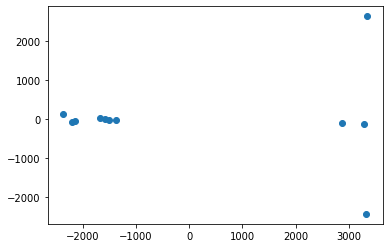

In [ ]:
plt.scatter(np.array(transformed[0]), np.array(transformed[1]))

In [ ]:
from sklearn.decomposition import PCA as sklearnPCA

In [ ]:
clusters = kmeans.cluster_centers_
print(clusters)

[[6.00000000e+00 3.33333333e+00 6.66666667e-01 1.00000000e+00
  3.34833333e+03 0.00000000e+00 3.33333333e-01 3.28200000e+03
  2.90600000e+03 0.00000000e+00]
 [1.60000000e+01 1.70000000e+01 3.20000000e+01 8.00000000e+00
  0.00000000e+00 3.00000000e+00 3.59800000e+03 3.48900000e+03
  2.95800000e+03 5.00000000e+00]
 [1.30771429e+03 7.05000000e+02 5.00857143e+02 3.92857143e+01
  1.14285714e+00 1.22714286e+02 9.00000000e+00 0.00000000e+00
  3.42857143e+00 1.90142857e+02]]


In [ ]:
y_km = kmeans.fit_predict(newMatrix)

In [ ]:
y_km

array([2, 2, 2, 2, 1, 2, 2, 0, 0, 0, 2], dtype=int32)

In [ ]:
candidates

['test', 'euro', 'amp']

final output events inshallah

In [ ]:
affprop.labels_

array([0, 1, 0, 0, 0, 0, 2, 1, 2, 2, 2, 1, 0, 3, 0, 1, 1, 2, 1, 3, 4, 1,
       5, 5, 0, 5, 6, 0, 3, 6, 0, 4, 5])

In [ ]:
candidates

In [ ]:
windows

In [ ]:
windows_dates

[datetime.datetime(2021, 6, 15, 6, 24),
 datetime.datetime(2021, 6, 15, 8, 24),
 datetime.datetime(2021, 6, 15, 10, 24),
 datetime.datetime(2021, 6, 15, 12, 24),
 datetime.datetime(2021, 6, 15, 14, 24),
 datetime.datetime(2021, 6, 23, 18, 0),
 datetime.datetime(2021, 6, 23, 20, 0)]

In [ ]:
events_windows = [[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0]]
# events_windows = [[0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0]]

In [ ]:
def bitOR(x1,x2):
  res = []
  for i in range(0,len(x1),1):
    if(x1[i] == 1 or x2[i] == 1):
      res.append(1)
    else:
      res.append(0)
  return res

for idx, clust in enumerate(affprop.labels_):
  events_windows[clust] = bitOR(events_windows[clust], windows[idx][0])

events_windows

[[1, 1, 1, 1, 0, 0, 1, 1],
 [1, 1, 0, 0, 1, 1, 1, 0],
 [0, 0, 1, 0, 0, 0, 0, 1],
 [0, 0, 1, 1, 0, 0, 1, 1],
 [0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 1, 0],
 [0, 0, 1, 0, 0, 0, 0, 0]]

In [ ]:
events_words = [[],[],[],[],[],[],[]]
# events_words = [[],[],[],[]]

for i in range(0,len(candidates),1):
  events_words[affprop.labels_[i]].append(candidates[i])


events_words

[['euro',
  'today',
  'tonight',
  'tomorrow',
  'year',
  'ita',
  'ticket',
  'man',
  'country',
  'hour'],
 ['player', 'copa', 'tournament', 'name', 'goal', 'top', 'friend'],
 ['position', 'dance', 'recently', 'englandas', 'still'],
 ['last', 'night', 'season'],
 ['scene', 'threelion'],
 ['trophy', 'champion', 'international', 'title'],
 ['history', 'record']]

In [ ]:
detected_events = pd.DataFrame()


def startDate(windows):
  for idx,num in enumerate(windows):
    if(num == 1):
      return windows_dates[idx]

for i in range(0,len(events_words),1):
  detected_events = detected_events.append(pd.Series([int(i), startDate(events_windows[i]), (" ".join(events_words[i])) ]), ignore_index=True)

detected_events.columns = ['Event number', 'start Date', 'event Keywords']

detected_events

,Event number,start Date,event Keywords
0,0.0,2021-07-09 21:46:00,euro today tonight tomorrow year ita ticket ma...
1,1.0,2021-07-09 21:46:00,player copa tournament name goal top friend
2,2.0,2021-07-10 21:31:00,position dance recently englandas still
3,3.0,2021-07-10 21:31:00,last night season
4,4.0,2021-07-10 21:31:00,scene threelion
5,5.0,2021-07-11 04:18:00,trophy champion international title
6,6.0,2021-07-10 21:31:00,history record


In [ ]:
def identity_tokenizer(text):
  return text

tfidf = TfidfVectorizer(tokenizer = identity_tokenizer, stop_words='english', lowercase=False)
result = tfidf.fit_transform(data_words_bigrams)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [ ]:
 tfidf.get_feature_names()[52451]

'tutorial'

In [ ]:
sectence_score = [[],[],[],[],[],[],[]]

In [ ]:
feature_names = tfidf.get_feature_names()

# doc = 1
# feature_index = result[doc,:].nonzero()[1]
# tfidf_scores = zip(feature_index, [result[doc, x] for x in feature_index])
for i in range(0,result.shape[0],1):
  score = [0,0,0,0,0,0,0]
  doc = i
  feature_index = result[doc,:].nonzero()[1]
  tfidf_scores = zip(feature_index, [result[doc, x] for x in feature_index])
  for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
    for j in range(0,len(events_words),1):
      if(w in events_words[j]):
        score[j]+=s
  for k in range(0,7,1):
    sectence_score[k].append(score[k])


In [ ]:
print(sectence_score[6])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3634802968032927, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3719266570096601, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.4559213046331045, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2987771213720706, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
#get the highest 5 sentences for each topic
top_5 = []

In [ ]:
a = [5,3,1,4,10,1,1,1,1,1,1,5,2,2,2]
top_5.append(sorted(range(len(sectence_score[0])), key=lambda i: sectence_score[3][i])[-15:])

In [ ]:
print(top_5[6])

[165875, 140632, 249800, 222825, 169245]


In [ ]:
detected_events

,Event number,start Date,event Keywords
0,0.0,2021-07-09 21:46:00,euro today tonight tomorrow year ita ticket ma...
1,1.0,2021-07-09 21:46:00,player copa tournament name goal top friend
2,2.0,2021-07-10 21:31:00,position dance recently englandas still
3,3.0,2021-07-10 21:31:00,last night season
4,4.0,2021-07-10 21:31:00,scene threelion
5,5.0,2021-07-11 04:18:00,trophy champion international title
6,6.0,2021-07-10 21:31:00,history record


In [ ]:
for i in range(0,5,1):
  print(" ".join(dataWords[top_5[6][i]]))

copa america the history behind brazil vrs argentina ahead of the final
copa amarica the probable teams the record that messi is looking for and the history againsta brazil
history is made
will history repeat itself england have record in major tournament finals italy have now wea
hope messi will win the copa america history


In [ ]:
for i in range(0,5,1):
  print(" ".join(dataWords[top_5[1][i]]))

nasa hurricane harvey seen from the cupola of the international space station
hurricane harvey seen from the cupola of the international space station hurricane harvey seen from the cupola
hurricane harvey seen from the cupola of the international space station hurricane harvey seen from the cupola
hurricane harvey seen from the cupola of the international space station hurricane harvey seen from the cupola
hurricane harvey seen from the cupola of the international space station hurricane harvey seen from the cupola of the space station


In [ ]:
for i in range(0,5,1):
  print(" ".join(dataWords[top_5[3][i]]))

here in the dfw metroplex where the skies reflect outer clouds encircling hurricane harvey down at the gulf fbs been dodgy for about an
guess im just gonna sit in my room and watch hurricane harvey hit base all day since theyre locking us in our rooms
all of our prayers to those who have been and will be affected by hurricane harvey prayfortexas
hurricane harvey texas battered by high winds and rain bbc news
hurricane harvey bashes texas coast leaving thousands without power homes damagedwe have emergency tarping services available if needed pictwittercomm ay eesiw


In [ ]:
events_words

[['category', 'landfall', 'mph', 'cat', 'rain', 'damage'],
 ['station', 'international_space', 'cupola', 'nasa'],
 ['notre_dame']]

In [ ]:
event_plots = [[0]*8,[0]*8,[0]*8,[0]*8,[0]*8,[0]*8,[0]*8]
# event_plots = [[0]*11,[0]*11,[0]*11,[0]*11]

for idx,event in enumerate(events_words):
  for word in event:
    index = onlyNouns.index(word)
    event_plots[idx] = np.add(np.array(targetTweetFreq[index]), np.array(event_plots[idx]) )


In [ ]:
total = [15993, 9006, 23193, 28994, 23930, 22262, 12232, 6462, 4841, 7320, 10933]

In [ ]:
event_plots[1]

array([ 4815,  1183,  7744, 10049,  2709, 12236,  8764,  2705])

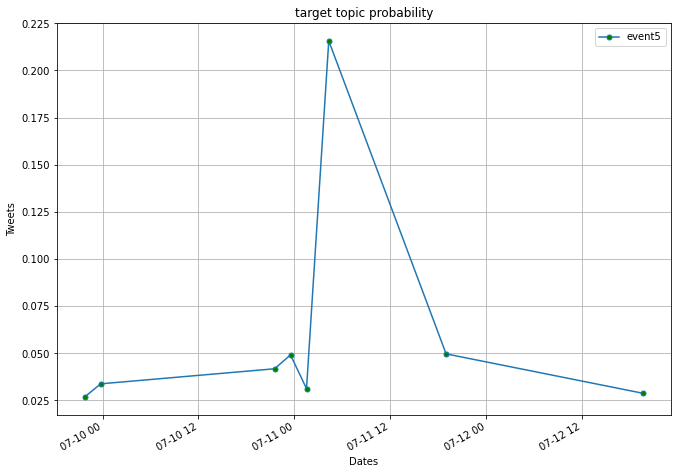

In [ ]:
# # line 1 points
# x1 = windows_dates
# y1 = event_plots[1]
# # plotting the line 1 points 
# plt.plot(x1, y1, label = "line 1",  marker='o', markerfacecolor='blue', markersize=5)

res = [i / j for i, j in zip(event_plots[5], time_slice)]

x2 = windows_dates
y2 = res
# plotting the line 2 points 
plt.plot(x2, y2, label = "line 2",  marker='o', markerfacecolor='green', markersize=5)

# x2 = windows_dates
# y2 = event_plots[2]
# # plotting the line 2 points 
# plt.plot(x2, y2, label = "line 2",  marker='o', markerfacecolor='black', markersize=5)

# x2 = windows_dates
# y2 = event_plots[3]
# # plotting the line 2 points 
# plt.plot(x2, y2, label = "line 2",  marker='o', markerfacecolor='black', markersize=5)

# x2 = windows_dates
# y2 = event_plots[4]
# # plotting the line 2 points 
# plt.plot(x2, y2, label = "line 2",  marker='o', markerfacecolor='black', markersize=5)

# x2 = windows_dates
# y2 = event_plots[5]
# # plotting the line 2 points 
# plt.plot(x2, y2, label = "line 2",  marker='o', markerfacecolor='black', markersize=5)

# x2 = windows_dates
# y2 = event_plots[6]
# # plotting the line 2 points 
# plt.plot(x2, y2, label = "line 2",  marker='o', markerfacecolor='black', markersize=5)
  
# line 2 points
# x2 = windows_dates
# y2 = time_slice
# # plotting the line 2 points 
# plt.plot(x2, y2, label = "line 2",  marker='o', markerfacecolor='red', markersize=5)
  
# naming the x axis
plt.xlabel('Dates')
# naming the y axis
plt.ylabel('Tweets')
# giving a title to my graph
plt.title('target topic probability')
  
# show a legend on the plot
plt.legend(["event5","all tweets","event2","all tweets"])
plt.gcf().autofmt_xdate()
plt.rcParams['figure.figsize'] = [11.0, 8.0]
plt.grid()

# function to show the plot
plt.show()

In [ ]:
event_plots[1]

array([ 4815,  1183,  7744, 10049,  2709, 12236,  8764,  2705])

In [ ]:
windows_dates

[datetime.datetime(2021, 7, 9, 21, 46),
 datetime.datetime(2021, 7, 9, 23, 46),
 datetime.datetime(2021, 7, 10, 21, 31),
 datetime.datetime(2021, 7, 10, 23, 31),
 datetime.datetime(2021, 7, 11, 1, 31),
 datetime.datetime(2021, 7, 11, 4, 18),
 datetime.datetime(2021, 7, 11, 18, 59),
 datetime.datetime(2021, 7, 12, 19, 35)]

In [ ]:
time_slice

[46709, 13806, 67244, 58804, 17717, 17999, 46037, 17999]

In [ ]:
detected_events

,Event number,start Date,event Keywords
0,0.0,8/25/2017 22:05,category landfall mph cat rain damage
1,1.0,8/25/2017 20:05,station international_space cupola nasa
2,2.0,8/26/2017 2:05,notre_dame
